In [82]:
# Develop multiagentsystem
from dotenv import load_dotenv
# we can customize the state as per requirement
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage,HumanMessage
from typing import Annotated,Sequence,TypedDict
from langgraph.graph import StateGraph,MessagesState,START,END

from langchain.tools import BaseTool
from typing import Dict
from langchain_groq import ChatGroq
from langgraph.types import Command

load_dotenv()

True

In [83]:
llm = ChatGroq(model="openai/gpt-oss-20b")

In [84]:
llm.invoke("hi")

AIMessage(content='Hello! How can I help you today?', additional_kwargs={'reasoning_content': 'We need to respond to user greeting. Probably friendly.'}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 72, 'total_tokens': 102, 'completion_time': 0.029829243, 'prompt_time': 0.003371635, 'queue_time': 0.049983715, 'total_time': 0.033200878, 'completion_tokens_details': {'reasoning_tokens': 12}}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_e99e93f2ac', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--56e9b495-eb36-4c7c-88dd-1d9bbf07a2bd-0', usage_metadata={'input_tokens': 72, 'output_tokens': 30, 'total_tokens': 102})

#  Designtools

In [ ]:
import os
tavily_api =  ""

In [86]:
tavily_api

'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'

In [87]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [88]:

search_tool = TavilySearchResults(tavily_api_key=tavily_api)

In [89]:
search_tool.run("Who is narendra modi")

[{'title': 'Narendra Modi - Wikipedia',
  'url': 'https://en.wikipedia.org/wiki/Narendra_Modi',
  'content': 'Narendra Damodardas Modi( (born 17 September 1950) is an Indian politician who has served as the prime minister of India since 2014. Modi was the chief minister of Gujarat from 2001 to 2014 and is the member of parliament (MP) for Varanasi "Varanasi (Lok Sabha constituency)"). He is a member of the Bharatiya Janata Party (BJP) and of the Rashtriya Swayamsevak Sangh (RSS), a right-wingHindutvaparamilitary volunteer organisation. He is the longest-serving prime minister outside the Indian',
  'score': 0.92074},
 {'title': 'Narendra Modi | Biography, Career, & Facts - Britannica',
  'url': 'https://www.britannica.com/biography/Narendra-Modi',
  'content': 'Narendra Modi (born September 17, 1950, Vadnagar, India) is an Indian politician and government official who rose to become a senior leader of the Bharatiya Janata Party (BJP). In 2014 he led his party to victory in elections to

In [90]:
# using REPL tool for runing python code
from langchain_experimental.utilities import PythonREPL

In [91]:
# code = """x = 10
# y = 20
# z = x+y
# print(z)"""

In [92]:
repr = PythonREPL()

In [93]:
from langchain.tools import BaseTool
from typing import ClassVar
from langchain_experimental.utilities import PythonREPL
from pydantic import PrivateAttr

class PythonREPLTool(BaseTool):

    name:ClassVar[str] = "repl_tool"
    
    description:ClassVar[str] = (
        "Execute Python code. "
        "Print values using print(...) to display output to the user."
    )

    _repr = PrivateAttr(default_factory= PythonREPL)

    def _run(self, code: Annotated[str,"Python code for chart creation"]):
        try:
            result = self._repr.run(code)
            return f"Successfully executed:\n```python\n{code}\n```\nOutput:\n{result}"
        except Exception as e:
            return f"Failed to execute. Error: {e}"

    async def _arun(self, code: str):
        raise NotImplementedError("Async not supported.")



In [94]:
repr_code_runner = PythonREPLTool()
# repr_code_runner.invoke(code)

In [95]:
members = ["researcher","coder"]

In [96]:
options = members +["FINISH"]

In [97]:
options

['researcher', 'coder', 'FINISH']

In [98]:
from typing import Literal
class Router(TypedDict):
    next:Literal["researcher","coder","FINISH"]

In [99]:
class State(MessagesState):
    next:str
state={"messages": ["hi"], "next": "research_agent"}

In [100]:
System_prompt = f"""
You are a supervisor managing a task delegation system with the following workers: {members}.

Your job is to decide which worker should act next based on the user’s input.

Guidelines:
- Carefully read the user’s message.
- If the message clearly requires a specific action (e.g., search, compute, rewrite), assign it to the appropriate worker.
- If the message is general, conversational, or does **not** require any specific action, immediately respond with `FINISH`.
- Do **not** invent tasks or assign actions unless the message clearly demands it.

Each worker will return results after completing their task.
Once all necessary tasks are completed, end the flow by responding with `FINISH`.

Be strict — if the message is casual, rhetorical, or lacks a clear task, reply with `FINISH`.
"""

In [101]:
# Designing Superviours multiagent

# Three Agent

In [102]:
from langgraph.types import Command
from langgraph.constants import END

def Supervisor_agent(state: State) -> Command[Literal["researcher", "coder", "__end__"]]:
    # Build conversational history
    messages = [
        {"role": "system", "content": System_prompt},
        *state["messages"]
    ]
    
    # Structured router LLM
    llm_router = llm.with_structured_output(Router)
    
    # Route decision
    response = llm_router.invoke(messages)
    
    print("**********BELOW IS MY GOTO***************")
    goto = response["next"]
    print("Supervisor decided:", goto)

    # --- FIX: handle LLM FINISH safely ---
    if goto == "FINISH":
        goto = "__end__"     # graph END alias
    if goto == "__end__":
        goto = END            # actual END constant

    # Update the state with next step
    return Command(
        goto=goto,
        update={"next": goto}
    )


In [103]:
from langgraph.prebuilt import create_react_agent




In [146]:



def researcher_agent(state:State)->Command[Literal["Supervisor"]]:
    print("I am in researcher")
    
    research_agent = create_react_agent(llm,tools = [search_tool],prompt="You are researcher. You can answer without using the search tool."
                                        )

    response = research_agent.invoke(state)

    return Command(update = {
        "messages":[HumanMessage(content=response["messages"][-1].content,name = "researcher")]
        
    },goto = "Supervisor")


In [147]:
# state  = {"messages": [("user", "What's the square root of 42?")]}
# researcher_agent(state)

In [150]:
def coder_agent(state:State) -> Command[Literal["Supervisor"]]:
    print("I am in coder")

    # Create the coder agent
    coder_react_agent = create_react_agent(
        llm,
        tools=[PythonREPLTool()],
        prompt="You are coder. You can answer without using PythonREPLTool."
    )


    # Invoke agent
    response = coder_react_agent.invoke(state)

    # Return Command to Supervisor
    return Command(
        update={
            "messages": [
                HumanMessage(content=response["messages"][-1].content, name="coder")
            ]
        },
        goto="Supervisor"
    )


In [153]:
# state  = {"messages": [("user", "What's the square root of 42?")]}
# coder_agent(state)

# Langgraph Orchestration

In [154]:
graph = StateGraph(State)


In [155]:
graph.add_node("Supervisor",Supervisor_agent)

graph.add_node("researcher",researcher_agent)

graph.add_node("coder",coder_agent)

In [ ]:
# edgesgit
graph.add_edge(START,"Supervisor")

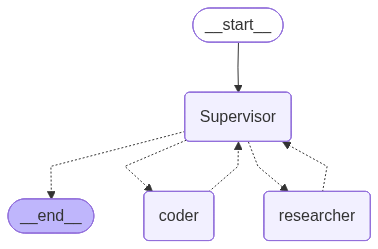

In [157]:
graph.compile()

In [158]:
app = graph.compile()

In [159]:
# result=app.invoke({"messages": [{"role": "user", "content": "what is square root of 35?"}]}
# , subgraphs=True)

In [161]:
for s in app.stream({
    "messages": [
        {"role": "user", "content": "what is age of narendra modi"}
    ]
}):
    print(s)

**********BELOW IS MY GOTO***************
Supervisor decided: researcher
{'Supervisor': {'next': 'researcher'}}
I am in researcher


C:\Users\pramo\AppData\Local\Temp\ipykernel_12880\884258138.py:4: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  research_agent = create_react_agent(llm,tools = [search_tool],prompt="You are researcher. You can answer without using the search tool."


{'researcher': {'messages': [HumanMessage(content='Narendra\u202fModi was born on **17\u202fSeptember\u202f1950**.  \nAs of today (29\u202fNovember\u202f2025) he is **75\u202fyears old** (he turned 75 on 17\u202fSeptember\u202f2025).', additional_kwargs={}, response_metadata={}, name='researcher', id='fbe38f23-d0a7-4971-9a97-9242f9d703f5')]}}


BadRequestError: Error code: 400 - {'error': {'message': 'Tool choice is required, but model did not call a tool', 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': 'FINISH'}}